In [60]:
import datetime as dt
import pandas as pd

import nltk
import re
import requests
import string

from bs4 import BeautifulSoup, Comment, NavigableString, SoupStrainer
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

In [35]:
class IndeedScraper:
    """ Class meant for scraping Indeed.com for specified job keywords and job locations"""

    def query_generator(self, keyword, location):
        """A function that takes a search keyword (or keywords) and a city and returns the resulting query url"""

        string1 = f"https://www.indeed.com/jobs?as_and={keyword}&as_phr=&as_any=&as_not=&as_ttl=&as_cmp=&jt=all&st=&"
        string2 = f"sr=directhire&as_src=&salary=&radius=50&l={location}&fromage=any&sort=&psf=advsrch"
        query = string1 + string2

        return query

    def search_results_numeric(self, query):
        '''A function that takes a search query url and returns the number of search results'''

        search_count = SoupStrainer(id="searchCount")
        page = requests.get(query)
        soup = BeautifulSoup(page.text, "html.parser", parse_only=search_count)
        s = soup.get_text()
        num_search_results = [int(item) for item in s.split(' ') if item.isdigit()][-1]
        result = "Number of job results:" + str(num_search_results)
        return num_search_results


    def search_page_generator(self, query, num_search_results, limit=50):
        '''A function that takes a query url and the number of search results corresponding that query, 
        and returns a list of urls to be scraped.'''

        urls_to_scrape = []
        converted_search_results = int(num_search_results)
        i = int(converted_search_results / 50)
        
        for page_number in range(i + 1):
            
            url_suffix = f'&limit={limit}&start={str(page_number * 50)}'
            url = f'{query}{url_suffix}'
            urls_to_scrape.append(url)
            
        return urls_to_scrape

    def make_soup(self, query, parser='html.parser'):

        '''A function that takes a query url and returns a BeautifulSoup object. html.parser is passed in as default parser'''

        page = requests.get(query)
        soup = BeautifulSoup(page.text, parser)

        return soup
    

    # Map iterables in urls_to_scrape into soup_generator()
    def extract_job_postings(self, url_list):
        """A function that takes a list of urls from search_page_generator() 
         and returns a list of BeautifulSoup objects corresponding to each job posting in the list of urls"""
    
        job_postings = []
        
        for url in url_list:
            
            soup = scraper.make_soup(url)
            for result in soup.find_all('div', attrs={'data-tn-component': 'organicJob'}):
                job_postings.append(result)
            
        return job_postings
    
    def process_job_posting(self, job):
        """
        Function that parses through html elements of indeed job postings and prints them in a prettified string output
        """
        
        # job id
        
        
        try:
            job_id = job.find('h2', attrs={"class": "jobtitle"})['id']
            #print("Job ID:", job_id)
        except AttributeError:
            job_id = 'NA'
        

        # job title
        try:
            job_title = job.find('a', attrs={'data-tn-element':"jobTitle"}).text.strip().capitalize()
        except AttributeError:
            job_title = 'NA'
        #print("Job Title:", job_title)

        # * company
        try:
            company = job.find('span', class_='company').text.strip()
        except AttributeError:
            company = 'NA'
        #print("Company:", company)

        # location
        try:
            location = job.find('span', class_='location').get_text()
        except AttributeError:
            location = 'NA'
        #print("Location:", location)
        
        # date_posting
        try:
            post_date = job.find('span', class_='date').get_text()
        except AttributeError:
            post_date = 'NA'
        #print("Date Posted:", post_date)
        
        
        # salary_range

        try:
            salary = job.find('span', class_='salary no-wrap').text.strip()
            #print("Salary:" , salary)
        except AttributeError:
            salary = 'NA'

        # job_summary

        summary = job.find('span', class_='summary').text.strip()
        #print("Job Summary:", summary)

        # job_link

        job_link = "https://www.indeed.com" + job.find('h2', attrs={"class": "jobtitle"}).find('a')['href']
        #print("Job_link:", job_link)
        
        # full description
        
        request = requests.get(job_link)
        request_soup = BeautifulSoup(request.text, "html.parser")
        description = request_soup.find('div', attrs={"class": "jobsearch-JobComponent-description"})
        description = description.text.strip()
        
        #print(description)
        return [job_id, job_title, company, location, post_date, salary, summary, job_link, description]
        



In [36]:
        
# =========================== EXAMPLE USAGE ==============================================
# init class object
scraper = IndeedScraper()
# define query with keyword/keywords and location
test_query = scraper.query_generator('tensorflow', "21044")
# store the amount of search results
num_search_results = scraper.search_results_numeric(test_query)
# create urls from query and associated number of jobs
urls = scraper.search_page_generator(test_query, num_search_results)

# you can skip this step, it's built into IndeedScraper.extract_job_postings(), just testing functionality
#soup = scraper.make_soup(test_query) 

# this opens all the links from the pages and stores their full text description for later use
job_postings = scraper.extract_job_postings(urls)

#============================================== debug ==============================================
#print(test_query)
print(num_search_results)
#print(urls)
#print(soup)
#print(len(job_postings))
#============================================== debug ==============================================

# verifying all is working
test = scraper.process_job_posting(job_postings[0])
print(test)

234
['jl_811a4c8376e92927', 'Geospatial programmer (12-10)', 'FREEDOM CONSULTING GROUP', 'McLean, VA', '9 hours ago', 'NA', 'Hello jobseeker! We are Freedom Consulting Group. Here, employees have the freedom to spread their creative wings. Freedom Consulting Group was founded with the...', 'https://www.indeed.com/rc/clk?jk=811a4c8376e92927&fccid=ebbc3022fb23d52b&vjs=3', 'Hello jobseeker! We are Freedom Consulting Group. Here, employees have the freedom to spread their creative wings. Freedom Consulting Group was founded with the idea of building a company free of encumbrances, a company in which employees have the freedom to be creative and innovative. It is that freedom, our love of technology, and the integrity of our employees that enable us to deliver exceptional solutions to our clients.\n\nCategory: GIS\n\nTitle: Geospatial Programmer (12-10)\n\nLocation(s): Position Available in Virginia\n\nSecurity Clearance: TS/SCI with appropriate agency Polygraph\n\nRequirements: Immediate O

# Move data to dataframe for processing

 This may take a bit to run depending on your query, try to narrow down what you want or you might be here a while.  
 If you get NA values, it's because i added in some ugly handling of getting past search limits with Indeed that stops the
 code from breaking

In [37]:
columns = ['ID', 'Title', 'Company', 'Location', 'Date', 'Salary', 'Summary', 'Link', 'FullText']
dataframe = pd.DataFrame(columns=columns)

In [38]:
for job_number in range(0, num_search_results - 1):
    dataframe.loc[len(dataframe)] = (scraper.process_job_posting(job_postings[job_number]))

In [39]:
dataframe = dataframe.applymap(str)
dataframe.head()

,ID,Title,Company,Location,Date,Salary,Summary,Link,FullText
0,jl_811a4c8376e92927,Geospatial programmer (12-10),FREEDOM CONSULTING GROUP,"McLean, VA",9 hours ago,NA,Hello jobseeker! We are Freedom Consulting Gro...,https://www.indeed.com/rc/clk?jk=811a4c8376e92...,Hello jobseeker! We are Freedom Consulting Gro...
1,jl_0d8e56aaaf2c4e63,Software engineer - machine learning,BTI360,"Ashburn, VA",5 hours ago,NA,Our customers are inundated with information f...,https://www.indeed.com/rc/clk?jk=0d8e56aaaf2c4...,Our customers are inundated with information f...
2,jl_a276ea2539679009,Yolo developer,K&M Systems,"Tysons Corner, VA",1 day ago,NA,"Job Description\n\nK&M Systems, Inc. is lookin...",https://www.indeed.com/rc/clk?jk=a276ea2539679...,"ContractJob Description\nK&M Systems, Inc. is ..."
3,jl_d9b23e575d4896c1,Software engineer/computer scientist,Johns Hopkins Applied Physics Laboratory (APL),"Laurel, MD 20708",4 months ago,NA,Are you looking for an opportunity that will k...,https://www.indeed.com/rc/clk?jk=d9b23e575d489...,Are you looking for an opportunity that will k...
4,jl_d6c135b508d2351e,Senior data engineer,University of Maryland Medical System,"Linthicum, MD",5 days ago,NA,What You Will Do:\n\nI. General Summary\n\nUnd...,https://www.indeed.com/rc/clk?jk=d6c135b508d23...,What You Will Do:\n\nI. General Summary\n\nUnd...


# 2) Use NLTK to tokenize / clean the listings


In [47]:
df_copy = dataframe.copy()
df_copy['FullText'] = df_copy['FullText'].str.replace('[^A-Za-z\s]+', ' ')
df_copy['FullText'] = df_copy['FullText'].str.replace('\n', ' ')

In [99]:
# pull job desc to series
words = df_copy['FullText']
print("Descriptions to move to string:" ,len(words))

print("\nExample description:\n", words[0])

Descriptions to move to string: 233

Example description:
 Hello jobseeker  We are Freedom Consulting Group  Here  employees have the freedom to spread their creative wings  Freedom Consulting Group was founded with the idea of building a company free of encumbrances  a company in which employees have the freedom to be creative and innovative  It is that freedom  our love of technology  and the integrity of our employees that enable us to deliver exceptional solutions to our clients   Category  GIS  Title  Geospatial Programmer    Location s  Position Available in Virginia  Security Clearance  TS SCI with appropriate agency Polygraph  Requirements  Immediate Opening  Levels  All Levels  Description   Technical tasks shall include the further development of a framework and models in Python utilize the machine learning  ML  framework TensorFlow and other standard data science libraries  e g  numpy  pandas  etc  to perform machine learning and deep learning  DL  tasks on ground and overhe

In [103]:
# series to string
words = words.astype(str)
words = ''.join(words)

AttributeError: 'str' object has no attribute 'astype'

In [105]:
print(len(words))

960326


In [107]:
word_tokens = nltk.pos_tag(word_tokenize(words))
print("Sum of words with valid parts of speech tags:", len(word_tokens))

Sum of words with valid parts of speech tags: 138585


In [108]:
# code from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def wordnet_part_of_speech(word):
    """Map POS tag to first character lemmatize() accepts"""
    
    # access list index, tuple index, map value
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [109]:
lemmatizer = WordNetLemmatizer()
pos_parsed_words = [lemmatizer.lemmatize(w, wordnet_part_of_speech(w)) for w in nltk.word_tokenize(words)]
pos_parsed_words = [word for word in pos_parsed_words if word.isalpha()]

In [110]:
stop_words = set(stopwords.words('english'))
pos_parsed_words = [word for word in pos_parsed_words if word not in stop_words]
pos_parsed_words = [word.upper() for word in pos_parsed_words]

In [112]:
print("Words post parts of speech processing:", len(pos_parsed_words))

Words post parts of speech processing: 96363


In [118]:
fdist = FreqDist(pos_parsed_words)
fdist.most_common(30)

[('EXPERIENCE', 1715),
 ('DATA', 1701),
 ('WORK', 1061),
 ('LEARN', 892),
 ('TEAM', 833),
 ('SOFTWARE', 731),
 ('MACHINE', 730),
 ('DEVELOPMENT', 714),
 ('WE', 610),
 ('YEAR', 559),
 ('USE', 524),
 ('SCIENCE', 512),
 ('TECHNOLOGY', 508),
 ('SOLUTION', 497),
 ('ANALYTICS', 488),
 ('DEVELOP', 454),
 ('CUSTOMER', 442),
 ('SECURITY', 415),
 ('TECHNICAL', 412),
 ('INCLUDE', 409),
 ('ENGINEERING', 390),
 ('OPPORTUNITY', 388),
 ('MODEL', 384),
 ('SKILL', 384),
 ('SYSTEM', 378),
 ('AWS', 377),
 ('THE', 371),
 ('BUSINESS', 366),
 ('DESIGN', 364),
 ('COMPUTER', 360)]

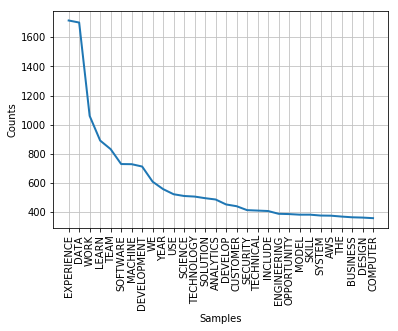

In [114]:
fdist.plot(30, cumulative=False)
plt.show()

# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [124]:
vectorizer = CountVectorizer(max_features=None, ngram_range=(1,1), stop_words='english')

vectorizer.fit(pos_parsed_words)
print(vectorizer.vocabulary_)

{'hello': 1891, 'jobseeker': 2227, 'freedom': 1693, 'consulting': 884, 'group': 1826, 'employee': 1359, 'spread': 3907, 'creative': 975, 'wing': 4497, 'idea': 1974, 'building': 530, 'company': 769, 'free': 1692, 'encumbrance': 1380, 'innovative': 2083, 'love': 2430, 'technology': 4098, 'integrity': 2121, 'enable': 1370, 'deliver': 1093, 'exceptional': 1491, 'solution': 3844, 'client': 690, 'category': 590, 'gis': 1780, 'title': 4172, 'geospatial': 1772, 'programmer': 3227, 'location': 2409, 'position': 3097, 'available': 368, 'virginia': 4400, 'security': 3698, 'clearance': 685, 'ts': 4258, 'sci': 3660, 'appropriate': 248, 'agency': 125, 'polygraph': 3084, 'requirements': 3501, 'immediate': 2000, 'opening': 2843, 'levels': 2348, 'description': 1126, 'technical': 4090, 'task': 4076, 'shall': 3743, 'include': 2026, 'far': 1579, 'development': 1154, 'framework': 1685, 'model': 2625, 'python': 3301, 'utilize': 4350, 'machine': 2438, 'learn': 2326, 'ml': 2613, 'tensorflow': 4113, 'standard'

In [125]:
vector_word_counts = vectorizer.transform(pos_parsed_words)

pos_vectorized = pd.DataFrame(vector_word_counts.toarray(), columns=vectorizer.get_feature_names())

In [126]:
pos_vectorized.shape

(96363, 4563)

In [127]:
pos_vectorized.head()

,aa,aap,aberdeen,abet,abilities,ability,able,abreast,abroad,abundant,...,yolo,youtu,yr,ytc,ywhzox,zaktaccardi,zeppelin,zero,zone,zookeeper
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 # 4) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [152]:
vectorizer = TfidfVectorizer()

bag_of_words = vectorizer.fit_transform(pos_parsed_words)
print(bag_of_words.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [153]:
pos_vectorized = pd.DataFrame(bag_of_words.toarray(), columns=vectorizer.get_feature_names())

In [154]:
pos_vectorized.shape

(96363, 4748)

In [155]:
pos_vectorized.head(30)

,aa,aap,aberdeen,abet,abilities,ability,able,about,abreast,abroad,...,your,youtu,yr,ytc,ywhzox,zaktaccardi,zeppelin,zero,zone,zookeeper
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Stretch Goals

 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.